<a href="https://colab.research.google.com/github/Diz138/YelpReviews/blob/main/Keras_Merged_Review_To_Popularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
import nltk
from collections import Counter
import string
import re
import seaborn as sns
import tensorflow as tf
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics

Connecting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checking to see if we are running GPU

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/CS525/yelp_compressed_reviews2.pkl")
df.head()

,business_id,stars,review_count,visits,visits_normalized,label,reviews_concatenated
0,MTSW4McQd7CbVtyjqoe9mw,4.0,80,335,27.916667,1,This is nice little Chinese bakery in the hear...
1,0bPLkL0QhhPO5kt1_EXmNQ,4.5,100,264,22.000000,1,The worst Chicken Parm. Sandwich I've ever eat...
2,MUTTqe8uqyMdBl186RmNeA,4.0,245,172,34.400000,1,Stopped in to check out this new spot around t...
3,ROeacJQwBeh05Rqg7F6TCg,4.5,205,221,24.555556,1,"This place is fantastic! Delicious, simple, h..."
4,9OG5YkX1g2GReZM0AskizA,2.5,339,508,42.333333,1,Great bar Happy Hour 4-7 every day. Wine & Dra...


In [ ]:
#subset = df[['reviews_concatenated','label']].sample(n=10000, random_state=8)
subset = df[['reviews_concatenated','label']]
subset.head()

,reviews_concatenated,label
0,This is nice little Chinese bakery in the hear...,1
1,The worst Chicken Parm. Sandwich I've ever eat...,1
2,Stopped in to check out this new spot around t...,1
3,"This place is fantastic! Delicious, simple, h...",1
4,Great bar Happy Hour 4-7 every day. Wine & Dra...,1


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
subset = subset.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

# Normalize text, remove stopwords and above symbols
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)  
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
subset['reviews_concatenated'] = subset['reviews_concatenated'].apply(clean_text)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each review text.
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(subset['reviews_concatenated'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1242595 unique tokens.


In [ ]:
# Convert text values to specified length, padding when necessary
X = tokenizer.texts_to_sequences(subset['reviews_concatenated'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (22367, 250)


In [ ]:
Y = pd.get_dummies(subset['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (22367, 5)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(20130, 250) (20130, 5)
(2237, 250) (2237, 5)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
284/284 [==============================] - 292s 1s/step - loss: 1.0621 - accuracy: 0.4809 - val_loss: 1.0417 - val_accuracy: 0.4853
Epoch 2/5
284/284 [==============================] - 287s 1s/step - loss: 0.9762 - accuracy: 0.5469 - val_loss: 1.0449 - val_accuracy: 0.5171
Epoch 3/5
284/284 [==============================] - 285s 1s/step - loss: 0.8061 - accuracy: 0.6562 - val_loss: 1.1076 - val_accuracy: 0.5117
Epoch 4/5
284/284 [==============================] - 278s 978ms/step - loss: 0.6173 - accuracy: 0.7498 - val_loss: 1.2080 - val_accuracy: 0.5097


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

70/70 [==============================] - 5s 66ms/step - loss: 1.1648 - accuracy: 0.5069
Test set
  Loss: 1.165
  Accuracy: 0.507


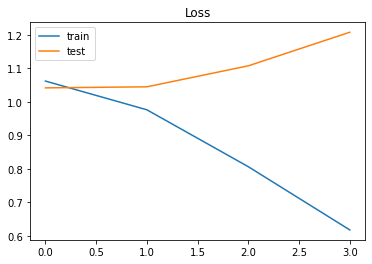

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                    
plt.show();


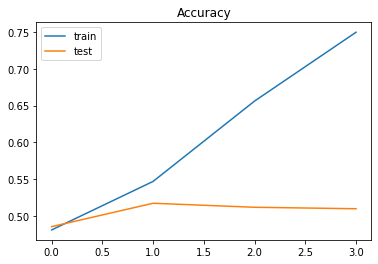

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [ ]:
predicted = model.predict(X_test)

70/70 [==============================] - 6s 74ms/step


In [ ]:
# Convert array of probabilities to actual value
predicted = np.argmax(predicted, axis=1)
Y_test = np.argmax(Y_test, axis=1)

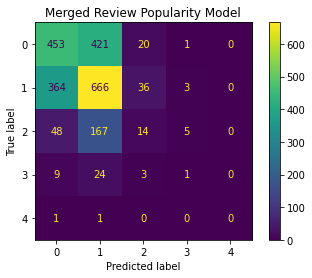

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4])

cm_display.plot()
plt.title("Merged Review Popularity Model")
plt.show() 
